In [112]:
import torch
import nibabel as nib
import os
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
import numpy as np
import time
from tqdm.auto import tqdm
import utils as utils

In [113]:
img = nib.load('/scratch/student/sinaziaee/datasets/3d_dataset/training/images/kidney_0001_0000.nii.gz').get_fdata()
img.shape

(512, 512, 240)

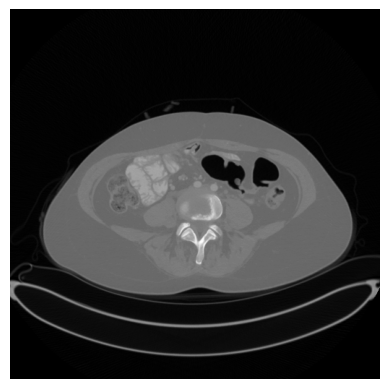

In [114]:
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

# Load the image
img = nib.load('/scratch/student/sinaziaee/datasets/3d_dataset/training/images/kidney_0001_0000.nii.gz').get_fdata()
img = img[:,:, 0]
# Rotate the image by 90 degrees
rotated_img = rotate(img, 90)

# Display the rotated image
plt.imshow(rotated_img, cmap='gray')
plt.axis('off')
plt.show()

In [198]:
import pickle

# Open the .pkl file
with open('final_result6/history_2.pkl', 'rb') as f:
    # Load the object from the file
    obj = pickle.load(f)

# Print the text inside the object
print(obj)


{'train_loss': [array(0.96726304, dtype=float32), array(0.97678286, dtype=float32)], 'valid_loss': [array(0.9672187, dtype=float32), array(0.85009736, dtype=float32)], 'dice_valid_score': [array(0.26444778, dtype=float32), array(0.26444778, dtype=float32)]}


In [188]:
import pickle

# Open the .pkl file
with open('final_result6/history_2.pkl', 'rb') as f:
    # Load the object from the file
    obj = pickle.load(f)

# Print the text inside the object
print(obj)

{'train_loss': [array(0.20302838, dtype=float32), array(0.0581545, dtype=float32)], 'valid_loss': [array(0.43225747, dtype=float32), array(0.41336077, dtype=float32)], 'dice_valid_score': [array(0.79268634, dtype=float32), array(0.7800589, dtype=float32)]}


In [174]:
len(os.listdir('final_dataset/train/image'))

13671

In [ ]:
from makedataset import makeDataset

# trainds = makeDataset(kind='train', location='data_npy')
# img, seg = trainds[300]
def plot_slices2(img, seg):
    # Squeeze the singleton dimension if it exists
    imaging_slice = np.transpose(img, (1, 2, 0))
    imaging_slice = np.squeeze(imaging_slice)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(imaging_slice, cmap='gray')
    ax[1].imshow(seg[1], cmap='Reds')
    # ax.set_title('Imaging Slice with Segmentation')
    # ax.axis('off')
    plt.show()

for i in [i*100 for i in range(0, 10)]:
    num =  '{:05d}'.format(i)
    img = np.load(f'./data_npy/test/image/{num}.npy')
    seg = np.load(f'./data_npy/test/segmentation/{num}.npy')
    # plot_slices2(img, seg)

In [47]:
def get_current_path(path=None):
    if path:
        return path
    else:
        return os.getcwd()

if not os.path.exists(f'{get_current_path()}/data_npy'):
    os.mkdir(f'{get_current_path()}/data_npy')
    
if not os.path.exists(f'{get_current_path()}/data_npy/train'):
    os.mkdir(f'{get_current_path()}/data_npy/train')
    
if not os.path.exists(f'{get_current_path()}/data_npy/valid'):
    os.mkdir(f'{get_current_path()}/data_npy/valid')
    
if not os.path.exists(f'{get_current_path()}/data_npy/test'):
    os.mkdir(f'{get_current_path()}/data_npy/test')
    
def make_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

train_image_path = make_path(f'{get_current_path()}/data_npy/train/image')
train_segment_path = make_path(f'{get_current_path()}/data_npy/train/segmentation')
valid_image_path = make_path(f'{get_current_path()}/data_npy/valid/image')
valid_segment_path = make_path(f'{get_current_path()}/data_npy/valid/segmentation')
test_image_path = make_path(f'{get_current_path()}/data_npy/test/image')
test_segment_path = make_path(f'{get_current_path()}/data_npy/test/segmentation')   

In [170]:
def perform_image_slicing(root_path, saving_path):
    count = 0
    depth_list = []
    for file_name in tqdm(sorted(os.listdir(root_path))):
        # print(os.path.join(root_path, file_name))
        if file_name.endswith('.nii.gz'):
            img_id = str(file_name.split('_')[1])
            img = nib.load(os.path.join(root_path, file_name)).get_fdata()
            # normalizing the image between 0 and 1
            img=(img-img.min())/(max((img.max()-img.min()),1e-3))
            depth = img.shape[2]
            depth_list.append(depth)
            for j in range(depth):
                # j = 100
                new_path=os.path.join(saving_path, '{:05d}.npy'.format(j+count))
                new_img = torch.tensor(img[:, :, j:j+1].astype(np.float32))
                new_img = new_img.permute(2, 0, 1)
                new_img = np.array(new_img)
                # plt.imshow(new_img[0], cmap='gray')
                # plt.axis('off')
                # plt.show()
            #     break
            # break
                np.save(new_path, new_img)
            count += depth
    return depth_list
train_depth_list = perform_image_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/training/images/', saving_path=train_image_path)
valid_depth_list = perform_image_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/validation/images/', saving_path=valid_image_path)
test_depth_list = perform_image_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/testing/images/', saving_path=test_image_path)



100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


In [171]:
import json

depth_lists = {
    'train': train_depth_list,
    'valid': valid_depth_list,
    'test': test_depth_list
}

json_file_path = 'data_npy/depth_lists.json'

with open(json_file_path, 'w') as json_file:
    json.dump(depth_lists, json_file)


In [167]:
import matplotlib.pyplot as plt
def perform_segment_slicing(root_path, saving_path):
    count = 0
    depth_list = []
    for file_name in tqdm(sorted(os.listdir(root_path))):
        # print(os.path.join(root_path, file_name))
        seg_id = str(file_name.split('_')[1]).split('.')[0]
        seg = nib.load(os.path.join(root_path, file_name)).get_fdata()
        seg_no_cancer=np.where(seg>0,1,0).astype(np.uint8)
        depth = seg_no_cancer.shape[2]
        depth_list.append(depth)
        for j in range(depth):
            new_path=os.path.join(saving_path, '{:05d}.npy'.format(j+count))
            seg_1ch=torch.tensor(seg_no_cancer[:, :,j:j+1],dtype=torch.int64)
            seg_2ch=F.one_hot(seg_1ch,num_classes=2)
            seg_2ch=torch.squeeze(seg_2ch.permute(3,0,1,2))
            seg_2ch=np.array(seg_2ch,dtype=np.uint8)
            # plt.imshow(seg_2ch[1,:,:], cmap='gray')
            # plt.show()
            np.save(new_path,seg_2ch)
        #     break
        # break
        count += depth

perform_segment_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/training/labels/', saving_path=train_segment_path)
perform_segment_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/validation/labels/', saving_path=valid_segment_path)
perform_segment_slicing(root_path='/scratch/student/sinaziaee/datasets/3d_dataset/testing/labels/', saving_path=test_segment_path)

  0%|          | 0/8 [00:00<?, ?it/s]

205


In [98]:
import matplotlib.pyplot as plt

def plot_slices(imaging_path, segmentation_path):
    imaging_slice = np.load(imaging_path)
    segmentation_slice = np.load(segmentation_path)

    # Squeeze the singleton dimension if it exists
    imaging_slice = np.transpose(imaging_slice, (1, 2, 0))
    imaging_slice = np.squeeze(imaging_slice)

    fig, ax = plt.subplots()
    ax.imshow(imaging_slice, cmap='gray')
    ax.imshow(segmentation_slice[1], cmap='Reds', alpha=0.3)
    ax.set_title('Imaging Slice with Segmentation')
    ax.axis('off')
    plt.show()

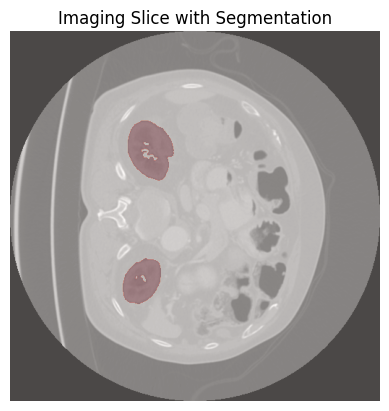

In [99]:
imaging_path = 'data_npy/test/image/00100.npy'
segmentation_path = 'data_npy/test/segmentation/00100.npy'
plot_slices(imaging_path, segmentation_path)

In [45]:
from dataset_creator import MyDataset
dataset = MyDataset('valid')

dataset[0][0][0].shape, dataset[0][1][1].shape

(torch.Size([512, 512]), torch.Size([512, 512]))

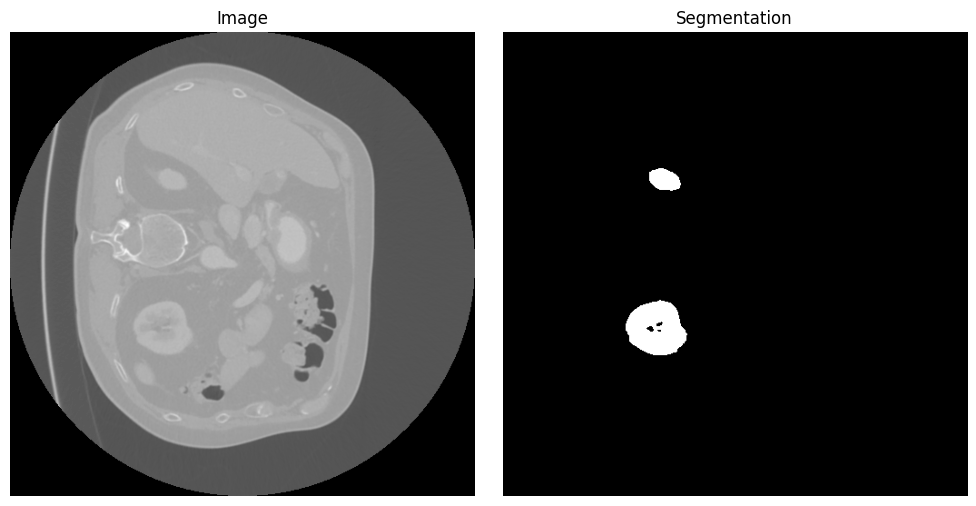

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display dataset[0][0] in the first subplot
axs[0].imshow(dataset[100][0][0], cmap='gray')
axs[0].set_title('Image')

# Display dataset[0][1] in the second subplot
axs[1].imshow(dataset[100][1][1], cmap='gray')
axs[1].set_title('Segmentation')

# Remove the axis labels
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()
